# 2019 Data Science Bowl
After exploratory data analysis and understanding the data, this notebook cleans up the raw data to make training data for modeling. 

Sourcee: [2019 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2019/overview)  
Author: Mike Lo  
Date modified: 10/30/2019


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Any results you write to the current directory are saved as output.
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from functools import reduce
from pandas.io.json import json_normalize #package for flattening json in pandas df

# from plotly import tools, subplots
# import plotly.offline as py
# py.init_notebook_mode(connected = True)
# import plotly.graph_objs as go
# import plotly.express as px
# pd.set_option('max_columns', 1000)
# from bokeh.models import Panel, Tabs
# from bokeh.io import output_notebook, show
# from bokeh.plotting import figure
# import lightgbm as lgb
# import plotly.figure_factory as ff
# import gc
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

input_dir = '../data/'
for dirname, _, filenames in os.walk(input_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/sample_submission.csv
../data/specs.csv
../data/test.csv
../data/train.csv
../data/train_labels.csv


# Information on the dataset

## Overview
In this dataset, you are provided with game analytics for the PBS KIDS Measure Up! app. In this app, children navigate a map and complete various levels, which may be activities, video clips, games, or assessments. Each assessment is designed to test a child's comprehension of a certain set of measurement-related skills. There are five assessments: Bird Measurer, Cart Balancer, Cauldron Filler, Chest Sorter, and Mushroom Sorter.

The intent of the competition is to use the gameplay data to forecast how many attempts a child will take to pass a given assessment (an incorrect answer is counted as an attempt). Each application install is represented by an `installation_id`. This will typically correspond to one child, but you should expect noise from issues such as shared devices. In the training set, you are provided the full history of gameplay data. In the test set, we have truncated the history after the start event of a single assessment, chosen randomly, for which you must predict the number of attempts. Note that the training set contains many `installation_ids` which never took assessments, whereas every `installation_id` in the test set made an attempt on at least one assessment.

## Datasets
__train.csv & test.csv__

These are the main data files which contain the gameplay events.  
`event_id` - Randomly generated unique identifier for the event type. Maps to event_id column in specs table.  
`game_session` - Randomly generated unique identifier grouping events within a single game or video play session.  
`timestamp` - Client-generated datetime  
`event_data` - Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise fields are determined by the event type.  
`installation_id` - Randomly generated unique identifier grouping game sessions within a single installed application instance.  
`event_count` - Incremental counter of events within a game session (offset at 1). _Extracted from event_data_.  
`event_code` - Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. _Extracted from event_data_.  
`game_time` - Time in milliseconds since the start of the game session. _Extracted from event_data_.  
`title` - Title of the game or video.  
`type` - Media type of the game or video. Possible values are: __Game__, __Assessment__, __Activity__, __Clip__.  
`world` - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: __NONE__ (at the app's start screen), __TREETOPCITY__ (Length/Height), __MAGMAPEAK__ (Capacity/Displacement), __CRYSTALCAVES__ (Weight).  

__specs.csv__

This file gives the specification of the various event types.  
`event_id` - Global unique identifier for the event type. Joins to event_id column in events table.  
`info` - Description of the event.  
`args` - JSON formatted string of event arguments. Each argument contains:  
`name` - Argument name.  
`type` - Type of the argument (string, int, number, object, array).  
`info` - Description of the argument.  

__train_labels.csv__

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):  
3) the assessment was solved on the first attempt  
2) the assessment was solved on the second attempt  
1) the assessment was solved after 3 or more attempts  
0) the assessment was never solved  

This is a classification problem (matching data from each `installation_id` to outcome).

## The goal
For each `installation_id` represented in the test set, you must predict the `accuracy_group` of the __LAST__ assessment for that `installation_id`.

# Load data
Load and get an overall sense of the data.

In [2]:
%time df = pd.read_csv(input_dir + 'train.csv') # takes a while to load 
print('Unique # of event types (event_ids): {}'.format(df['event_id'].unique().size))
print('Unique # of event classes (event_codes): {}'.format(df['event_code'].unique().size))
print('Unique # of activity types (type): {}'.format(df['type'].unique().size))
print('Unique # of titles (title): {}'.format(df['title'].unique().size))
print('Unique # of worlds (world): {}'.format(df['world'].unique().size))

CPU times: user 1min 41s, sys: 9.49 s, total: 1min 50s
Wall time: 2min 19s
Unique # of event types (event_ids): 384
Unique # of event classes (event_codes): 42
Unique # of activity types (type): 4
Unique # of titles (title): 44
Unique # of worlds (world): 4


In [3]:
# sample first 10 IDs from the full df
# print(df['installation_id'].unique()[:10])
df1 = df[df['installation_id'].isin(df['installation_id'].unique()[:10])]
print(df1.shape)

(11091, 11)


In [4]:
# find IDs with type that contains 'Assessment'
iids = df.iloc[np.where(df.loc[0:1e5, 'title'].str.contains('Assessment').tolist())]['installation_id'].unique()
print('Number of unique installs: {}'.format(iids.size))

Number of unique installs: 43


In [58]:
# get entries with IDs containing "Assessment" in the title. These are 
df1 = df[df['installation_id'].isin(iids)].copy()
df1['timestamp'] = pd.to_datetime(df1['timestamp'])
df1['hour_of_day'] = df1['timestamp'].dt.hour
df1.info()
df1.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78085 entries, 1538 to 101858
Data columns (total 12 columns):
event_id           78085 non-null object
game_session       78085 non-null object
timestamp          78085 non-null datetime64[ns, UTC]
event_data         78085 non-null object
installation_id    78085 non-null object
event_count        78085 non-null int64
event_code         78085 non-null int64
game_time          78085 non-null int64
title              78085 non-null object
type               78085 non-null object
world              78085 non-null object
hour_of_day        78085 non-null int64
dtypes: datetime64[ns, UTC](1), int64(4), object(7)
memory usage: 7.7+ MB


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,hour_of_day
101854,d3268efa,07d386012a71175a,2019-09-17 12:32:42.450000+00:00,"{""description"":""Look! Each bucket is exactly t...",0235fe9a,50,3021,27022,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,12
101855,b5053438,07d386012a71175a,2019-09-17 12:32:48.483000+00:00,"{""description"":""Look! Each bucket is exactly t...",0235fe9a,51,3121,33053,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,12
101856,532a2afb,07d386012a71175a,2019-09-17 12:32:48.503000+00:00,"{""buckets"":[],""target_bucket"":1,""mode"":""select...",0235fe9a,53,2020,33053,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,12
101857,923afab1,07d386012a71175a,2019-09-17 12:32:48.503000+00:00,"{""description"":""Tap the bucket that holds the ...",0235fe9a,52,3010,33053,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,12
101858,27253bdc,5eff3b055a3583a3,2019-09-17 12:33:13.148000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0235fe9a,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES,12


In [6]:
df1[df1['installation_id'] == '0006a69f'].tail()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,hour_of_day
5334,832735e1,0721802df0531701,2019-08-29 16:33:53.227000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,11,3010,23145,Dino Dive,Game,MAGMAPEAK,16
5335,ab3136ba,0721802df0531701,2019-08-29 16:33:56.880000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,12,3110,26804,Dino Dive,Game,MAGMAPEAK,16
5336,832735e1,0721802df0531701,2019-08-29 16:34:11.881000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,13,3010,41805,Dino Dive,Game,MAGMAPEAK,16
5337,ab3136ba,0721802df0531701,2019-08-29 16:34:15.480000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,14,3110,45405,Dino Dive,Game,MAGMAPEAK,16
5338,76babcde,0721802df0531701,2019-08-29 16:39:12.615000+00:00,"{""coordinates"":{""x"":1013,""y"":195,""stage_width""...",0006a69f,15,4070,167337,Dino Dive,Game,MAGMAPEAK,16


# Check labels

In [106]:
labels = pd.read_csv(input_dir + 'train_labels.csv')
labels[labels['installation_id'] == '0006a69f']
training_labels = labels.groupby('installation_id').last().reset_index()
training_labels.head()

,installation_id,game_session,title,num_correct,num_incorrect,accuracy,accuracy_group
0,0006a69f,a9ef3ecb3d1acc6a,Bird Measurer (Assessment),1,0,1.0,3
1,0006c192,b2297d292892745a,Mushroom Sorter (Assessment),0,4,0.0,0
2,00129856,ae691ec5ad5652cf,Bird Measurer (Assessment),1,0,1.0,3
3,001d0ed0,dc6bc0284039c9fb,Mushroom Sorter (Assessment),1,0,1.0,3
4,00225f67,619b9c069cf790ca,Bird Measurer (Assessment),0,2,0.0,0


# Feature engineering
Ideas (for each `installation_id`):
* is past assessment performances indicative of last assessment performance? (one user can have multiple assessments)
* average time spent in each assessment?
* average `game_time` between each event?
* average of max `event_count` per activity (between assessments)?
* how many previous assessments were done by the user? 
* most frequently used `event_code`?
* most frequently used `type`?
* most frequently used `title`?
* hour of the day during the assessment?
* 


In [8]:
df1.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,hour_of_day
1538,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,4
1539,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,4
1540,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,4
1541,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,4
1542,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,4


In [9]:
# test 
# find max # of different activities per user
# df1.groupby(['installation_id', 'title']).unique()
# df1.groupby('installation_id')['title'].nunique()
# df1[df1['title'].str.contains('Assessment')].groupby('installation_id')['title'].nunique()
# df1[df1['title'].str.contains('Activity')].groupby('installation_id')['title'].nunique()
# df1.groupby(['installation_id', 'title'])['event_count'].max().groupby('installation_id').mean()

# def code_counts(x):
    
df1.groupby('installation_id')['event_code'].value_counts().groupby('installation_id').transform(lambda x: x/x.sum())
# df1.groupby(['installation_id', 'event_code']).counts()

installation_id  event_code
0006a69f         3010          0.163115
                 3110          0.160484
                 4070          0.155748
                 4030          0.123915
                 4020          0.106288
                                 ...   
0235fe9a         2075          0.000788
                 4031          0.000788
                 4095          0.000788
                 2010          0.000394
                 2070          0.000394
Name: event_code, Length: 1196, dtype: float64

In [42]:
# test get ratio of event_codes within each ID
dft = df1.groupby('installation_id')['event_code'].value_counts().groupby(
    'installation_id').transform(lambda x: x/x.sum()).reset_index(name='code_ratio').pivot(
    index='installation_id', columns='event_code', values='code_ratio').fillna(value=0).reset_index()
dft.head()

event_code,installation_id,2000,2010,2020,2025,2030,2035,2040,2050,2060,...,4080,4090,4095,4100,4110,4220,4230,4235,5000,5010
0,0006a69f,0.021047,0.001052,0.029466,0.003157,0.025520,0.002105,0.005525,0.004736,0.001842,...,0.000000,0.001052,0.000526,0.003420,0.003683,0.003420,0.006577,0.006577,0.003157,0.003157
1,0006c192,0.022482,0.000000,0.023381,0.000899,0.020234,0.000899,0.002698,0.002248,0.000450,...,0.000000,0.001799,0.000450,0.002698,0.000899,0.002248,0.002698,0.002698,0.000000,0.000000
2,00129856,0.010843,0.001205,0.025301,0.001205,0.022892,0.000000,0.000000,0.000000,0.000000,...,0.007229,0.014458,0.000000,0.001205,0.001205,0.000000,0.000000,0.000000,0.000000,0.000000
3,001d0ed0,0.050584,0.002918,0.050584,0.001946,0.042802,0.001946,0.009728,0.008755,0.000000,...,0.000000,0.001946,0.001946,0.008755,0.004864,0.000000,0.000000,0.000000,0.000000,0.000000
4,00225f67,0.026123,0.000000,0.012539,0.003135,0.009404,0.000000,0.000000,0.000000,0.001045,...,0.000000,0.000000,0.001045,0.000000,0.002090,0.000000,0.000000,0.000000,0.000000,0.000000


In [139]:
df1.groupby(['installation_id', 'title'])[['game_time']].max().groupby('installation_id').sum().reset_index()

,installation_id,game_time
0,0006a69f,3608430
1,0006c192,1922277
2,00129856,947453
3,001d0ed0,1131817
4,00225f67,850093
5,00279ac5,5790308
6,002db7e3,3210170
7,003372b0,2321405
8,004c2091,397559
9,00634433,347023


In [140]:
def prepare_input(df, train=True):
    '''
    function to generate all training data from the raw dataset
    '''
    if train: 
        cdf = training_labels.copy()
    elif not train:
        cdf = df[['game_session']].copy()
        
    # get number of assessments, acitivities, and all different types of activities per ID
    num_assessments = df[(df['title'].str.contains('Assessment')) &
                               (df['event_count'] == 1)].groupby('installation_id').size() - 1
    num_assessments = num_assessments.reset_index(name='num_assessments')
    num_activities = df[(df['title'].str.contains('Activity')) &
                              (df['event_count'] == 1)].groupby('installation_id').size() - 1
    num_activities = num_activities.reset_index(name='num_activities')
    num_tot_activities = df[(df['event_count'] == 1)].groupby('installation_id').size() - 1
    num_tot_activities = num_tot_activities.reset_index(name='num_tot_activities')
    
    # get sum of all game_time from all activities per ID
    max_game_time = df.groupby(['installation_id', 'title'])[['game_time']].max().groupby('installation_id').sum().reset_index()
    
    # get mean # of activity event counts per ID
    mean_counts = df.groupby(['installation_id', 'title'])[['event_count']].max().groupby('installation_id').mean().reset_index()

    # get percentage of event_codes 
    event_codes = df.groupby('installation_id')['event_code'].value_counts().groupby(
    'installation_id').transform(lambda x: x/x.sum()).reset_index(name='code_ratio').pivot(
    index='installation_id', columns='event_code', values='code_ratio').fillna(value=0).reset_index()
    
    # create hour_of_day of game play
    hour_of_day = df.groupby('installation_id')[['hour_of_day']].mean().reset_index()
    
    # map world, type and title to labels
#     map_world = dict(zip(df['game_session'].tolist(), df['world'].tolist()))
#     map_type = dict(zip(df['game_session'].tolist(), df['type'].tolist()))
#     map_title = dict(zip(df['game_session'].tolist(), df['title'].tolist()))    
#     cdf['world'] = cdf['game_session'].map(map_world)
#     cdf['type'] = cdf['game_session'].map(map_type)
    
    # create normalized count of event_code per code
#     max_event_code = df.groupby(['game_session', 'event_code']).size().sort_values().max(level=0).to_frame(name='event_code_mode')
#     cdf = cdf.messrge(right=code_mode_event, on='game_session', how='inner')    
    
    # create max_event_count
#     max_event_counts = df.groupby('game_session')[['event_count']].max().reset_index()
#     max_event_counts.rename(columns = {'event_count':'max_event_counts'}, inplace=True)
        
    # add mean_game_time
#     mean_event_time = df.groupby('game_session')[['game_time']].mean().reset_index()
#     mean_event_time.rename(columns = {'game_time':'mean_event_time'}, inplace=True)
#     cdf.merge(right=mean_game_time, on='game_session', how='inner')

    # pivot and create one hot encoding for event_code
#     event_codes = df.groupby(['game_session', 'event_code']).size().to_frame(name='counts').reset_index()
#     event_codes = event_codes.pivot(index='game_session', columns='event_code', values='counts')
#     event_codes[event_codes.isna()] = 0
#     event_codes.reset_index(inplace=True)
#     event_codes.iloc[:, 1:] = event_codes.iloc[:, 1:].astype(int)
    
    # get all game titles

    # merge dfs
    dfs = [cdf, 
           num_assessments, 
           num_activities, 
           num_tot_activities, 
           max_game_time,
           mean_counts,
           hour_of_day,
           event_codes]
    cdf = reduce(lambda left, right: pd.merge(left, right, on='installation_id', how='inner'), dfs)
    
    # one hot encode
#     cdf = pd.get_dummies(cdf, columns=['world', 'type'])
    return cdf

In [145]:
# prepare training data
cdf = prepare_input(df1).reset_index()
cdf = cdf[['accuracy_group'] + [c for c in cdf if c not in ['accuracy_group', 
                                                           'game_session', 
                                                           'title',
                                                           'num_correct',
                                                           'num_incorrect',
                                                           'accuracy',
                                                           'index']]]
cdf.head()

,accuracy_group,installation_id,num_assessments,num_activities,num_tot_activities,game_time,event_count,hour_of_day,2000,2010,...,4080,4090,4095,4100,4110,4220,4230,4235,5000,5010
0,3,0006a69f,5,16,79,3608430,69.642857,11.927124,0.021047,0.001052,...,0.000000,0.001052,0.000526,0.003420,0.003683,0.003420,0.006577,0.006577,0.003157,0.003157
1,0,0006c192,3,7,49,1922277,64.258065,9.882644,0.022482,0.000000,...,0.000000,0.001799,0.000450,0.002698,0.000899,0.002248,0.002698,0.002698,0.000000,0.000000
2,3,00129856,1,5,8,947453,107.714286,15.953012,0.010843,0.001205,...,0.007229,0.014458,0.000000,0.001205,0.001205,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,001d0ed0,5,1,51,1131817,31.964286,13.995136,0.050584,0.002918,...,0.000000,0.001946,0.001946,0.008755,0.004864,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,00225f67,1,3,24,850093,38.280000,9.661442,0.026123,0.000000,...,0.000000,0.000000,0.001045,0.000000,0.002090,0.000000,0.000000,0.000000,0.000000,0.000000


# Modeling and evaluation

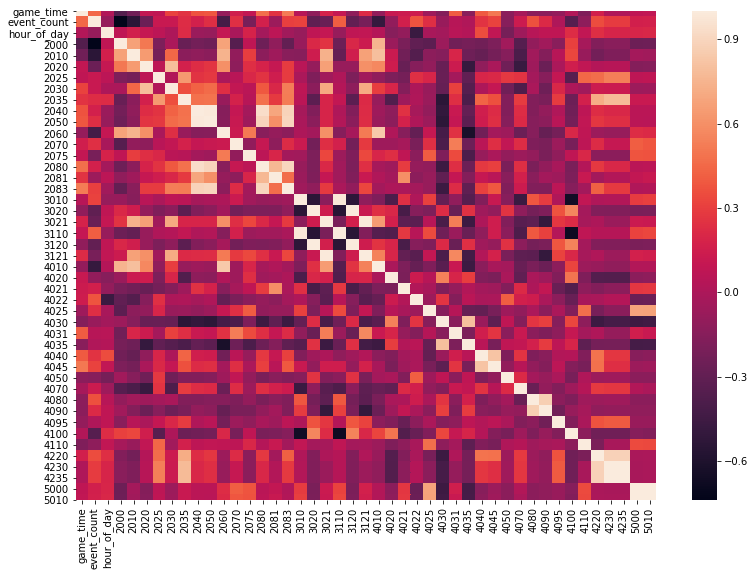

In [146]:
# correlation matrix
_, ax = plt.subplots(figsize=(13,9))
corr = cdf.iloc[:, 5:].corr()
sns.heatmap(corr);

# Modeling
Set up a basic skeleton for modeling.

In [147]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [148]:
X = cdf.iloc[:, 2:]
y = cdf.iloc[:, 0]

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [150]:
xg_reg = xgb.XGBClassifier(objective='reg:linear', 
                          colsample_bytree=0.3,
                          learning_rate=0.1,
                          max_depth=5,
                          alpha=10, 
                          n_estimators=10)

xg_reg.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [151]:
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print('RMSE: {}'.format(rmse))

RMSE: 1.3093073414159542


# Evaluation

In [152]:
# define quadratic_weighted_kappa for evaluation
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator

In [153]:
kappa = quadratic_weighted_kappa(preds, y_test)
kappa

0.5333333333333333

# Predict unknown data

In [155]:
stop here

SyntaxError: invalid syntax (<ipython-input-155-a96ba3aab008>, line 1)

In [72]:
%time test = pd.read_csv(input_dir + '/test.csv')

CPU times: user 4.69 s, sys: 224 ms, total: 4.92 s
Wall time: 4.92 s


In [73]:
df_test = test.copy()
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test['hour_of_day'] = df_test['timestamp'].dt.hour
df_test = prepare_input(df_test, train=False)
df_test.drop(columns=['game_session', 'world_NONE', 'type_Activity', 'type_Clip', 'type_Game'], inplace=True)

In [99]:
# df[df['installation_id'] == df['installation_id'].iloc[0]]
df[df['installation_id'] == df['installation_id'].iloc[100]]['title'].unique()

array(['Welcome to Lost Lagoon!', 'Magma Peak - Level 1',
       'Sandcastle Builder (Activity)', 'Scrub-A-Dub',
       'Magma Peak - Level 2', 'Dino Drink', 'Tree Top City - Level 1',
       'Ordering Spheres'], dtype=object)

In [94]:
print(test.shape)
# df_test['instal']
# test[(test['installation_id'] == '00abaee7') & (test['event_id'] == '832735e1')].tail(30)#['title']#.unique()
# test[test['installation_id'] == '00abaee7'].tail(40)#['title']#.unique()
test[test['installation_id'] == '00abaee7']['title'].unique()

(1156414, 11)


array(['Welcome to Lost Lagoon!', 'Magma Peak - Level 1',
       'Magma Peak - Level 2', 'Crystal Caves - Level 1', 'Chow Time',
       'Balancing Act', 'Crystal Caves - Level 2',
       'Tree Top City - Level 1', 'All Star Sorting', 'Costume Box',
       'Fireworks (Activity)', '12 Monkeys', 'Lifting Heavy Things',
       'Cart Balancer (Assessment)', 'Crystal Caves - Level 3',
       'Egg Dropper (Activity)', 'Bug Measurer (Activity)',
       'Sandcastle Builder (Activity)', 'Dino Dive',
       'Cauldron Filler (Assessment)'], dtype=object)

In [75]:
# make predictions
test_preds = xg_reg.predict(df_test)

In [76]:
# prepare predictions for submission
# sample = pd.read_csv(input_dir + 'sample_submission.csv')
# sample
results = pd.DataFrame({'installation_id':test['installation_id'], 'accuracy_group':test_preds})
results.head()

,installation_id,accuracy_group
0,00abaee7,3
1,00abaee7,3
2,00abaee7,3
3,00abaee7,0
4,00abaee7,1


In [77]:
# submit results
# results.to_csv('submission.csv', index=False)